In [1]:
#move to data/audio folder from ~/notebooks/
%cd ../data/audio

C:\Users\lexokan\Dropbox\R and Python\generativeMusic\data\audio


In [137]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import glob
import re
import tensorflow.keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from random import shuffle
import librosa
import librosa.display

In [6]:
file_list = glob.glob('*.wav')

#build spectrograms for conv net
spectrograms = []
for audio_file in file_list:
    sample_rate, samples = wavfile.read(audio_file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    np.place(spectrogram, spectrogram == 0, 10**-10) #avoid div by 0 for log
    
    audio_raw_name = re.search('.+?(?=\.wav)', audio_file).group(0) #remove .wav extension
    
    with open('../annotations/meter/' + audio_raw_name + '.meter', 'r') as file:
        meter = file.readline()
    
    spectrograms.append([audio_raw_name, np.log(spectrogram), meter])
    
#clean spectrograms data
invalid_songs = [[],[]]
for index, x in enumerate(spectrograms):
    if(x[1].shape != (129, 23624)):
        invalid_songs[0].append(index)
        invalid_songs[1].append(x[0])

for i in sorted(invalid_songs[0], reverse= True):
    del spectrograms[i]

In [63]:
import math

def spec_window(times, spectrogram, window):
    spectrogram_window = np.zeros((spectrogram.shape[0], math.ceil(spectrogram.shape[1]/window)), dtype = 'float32')
    times_window = np.zeros((math.ceil(times.shape[0]/window),), dtype = 'float32')
    for i in range(0, spectrogram.shape[1], window):
        if (i + window < spectrogram.shape[1]):
            spectrogram_window[:,int(i/window)] = np.mean(spectrogram[:, i:i+window], axis= 1)
            times_window[int(i/window)] = np.mean(times[i:i+window])
        else:
            spectrogram_window[:,int(i/window)] = np.mean(spectrogram[:, i:], axis = 1)
            times_window[int(i/window)] = np.mean(times[i:])

    return times_window, spectrogram_window

def spec_plot(times, frequencies, spectrogram, title):
    plt.pcolormesh(times, frequencies, np.log(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.show()

In [146]:
import copy
spectrograms_conv = copy.deepcopy(spectrograms) #don't want to change original, deepcopy to copy objs in list
dummy = np.zeros((spectrograms[0][1].shape[1],), dtype = 'float32')
for index, rows in enumerate(spectrograms):
    _, spectrograms_conv[index][1] = spec_window(dummy, rows[1], 150)

In [150]:
# for i in range(len(spectrograms)):
#     print(spectrograms[i][2])
print(spectrogram[0])
    
# Nonnegative Matrix Factorization
# x, sr = spectrogram[0]
#S = librosa.effects.percussive(spectrogram[0])
#S = librosa.decompose.hpss(spectrogram[0])

# S_db = librosa.amplitude_to_db(abs(S))

# plt.figure(figsize=(15, 5))
# librosa.display.specshow(S_db, sr=2000, x_axis='time', y_axis='log')
# plt.colorbar()

[1.0000000e-10 1.0000000e-10 1.0000000e-10 ... 3.3387566e-01 3.0386728e+01
 3.9717121e+01]


IndexError: tuple index out of range

<Figure size 1080x360 with 0 Axes>

In [14]:
len(spectrograms) * .7 #80

def load_data(spec_data):
    
    x_train = np.array([x[1] for x in spec_data[:80]])
    y_train = np.array([x[2] for x in spec_data[:80]])
    
    x_test = np.array([x[1] for x in spec_data[80:]])
    y_test = np.array([x[2] for x in spec_data[80:]])
    
    #print(x_train.shape)
    
    return (x_train, y_train), (x_test, y_test)

shuffle(spectrograms_conv) #shuffle spectrogram data

In [17]:
batch_size = 1
num_classes = 4
epochs = 10

# input image dimensions
img_x, img_y = spectrograms_conv[0][1].shape

# load the spectrogram data
(x_train, y_train), (x_test, y_test) = load_data(spectrograms_conv)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x_train.reshape(x_train.shape[0]*img_x, img_y))
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# RGB colour images would have 3, spectrogram data has 1
x_train = scaler.transform(x_train.reshape(x_train.shape[0]*img_x, img_y)).reshape((x_train.shape[0],img_x, img_y,1))

scaler.fit(x_test.reshape(x_test.shape[0]*img_x, img_y))
x_test = scaler.transform(x_test.reshape(x_test.shape[0]*img_x, img_y)).reshape((x_test.shape[0],img_x, img_y,1))


input_shape = (img_x, img_y, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_test shape:', x_train.shape)
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below

le = LabelEncoder()
le.fit(y_train)
y_train = tensorflow.keras.utils.to_categorical(le.transform(y_train), num_classes)
y_test = tensorflow.keras.utils.to_categorical(le.transform(y_test), num_classes)

#del spectrograms

x_train shape: (80, 129, 158, 1)
80 train samples
x_test shape: (80, 129, 158, 1)
34 test samples


In [99]:
print(y_test)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [20]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(24, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

class AccuracyHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])

Train on 80 samples, validate on 34 samples
Epoch 1/10
80/80 [==============================] - 54s 678ms/step - loss: 1.4534 - acc: 0.2750 - val_loss: 1.3862 - val_acc: 0.2647
Epoch 2/10
80/80 [==============================] - 9s 117ms/step - loss: 1.4422 - acc: 0.3000 - val_loss: 1.3964 - val_acc: 0.2059
Epoch 3/10
80/80 [==============================] - 9s 116ms/step - loss: 1.4017 - acc: 0.3750 - val_loss: 1.3865 - val_acc: 0.2647
Epoch 4/10
80/80 [==============================] - 9s 115ms/step - loss: 1.2650 - acc: 0.4625 - val_loss: 1.3700 - val_acc: 0.2647
Epoch 5/10
80/80 [==============================] - 9s 116ms/step - loss: 1.0707 - acc: 0.6000 - val_loss: 1.4827 - val_acc: 0.2941
Epoch 6/10
80/80 [==============================] - 10s 124ms/step - loss: 0.6919 - acc: 0.7875 - val_loss: 2.8788 - val_acc: 0.2059
Epoch 7/10
80/80 [==============================] - 10s 119ms/step - loss: 0.3847 - acc: 0.8500 - val_loss: 2.4231 - val_acc: 0.1765
Epoch 8/10
80/80 [===========

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.654443158822901
Test accuracy: 0.23529411764705882


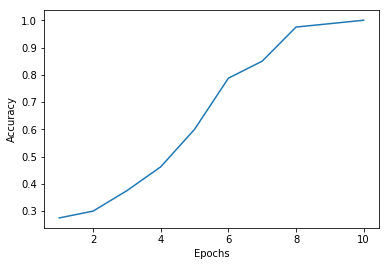

In [22]:
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [23]:
del model

In [24]:
from sklearn.preprocessing import MinMaxScaler

data = np.array([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])
scaler = MinMaxScaler()
print(scaler.fit(data))
print(scaler.data_max_)
print(scaler.transform(data))
print(scaler.transform([[2, 2]]))

MinMaxScaler(copy=True, feature_range=(0, 1))
[ 1. 18.]
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
[[1.5 0. ]]
